So far we have been exploring *Classical Reinforcement Learning* methods. Most of the 90s were spent generalising Q-Learning and other successful classical methods. Most of the struggle stemmed from finding the best and most efficient way to extend the methods to problems with expanded state-spaces - **large discountinous spaces** with greater number of dimensions or even **continuous spaces**.

Typical solutions to the problem of *large state-spaces* were explored,

* discretisation
* tiling
* kernels

with different levels of success.

It was only when *Neural Networks* and **Deep Learning** came along as one of the most **efficient method of function approximation** that *Reinforcement Learning* had a new bout of renewed interest and intense development by the Research Community - as an overwhelmingly wider spectrum of problems started to become accessible and successfully tackled.

# Deep Reinforcement Learning

In early 2015, [DeepMind](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf) made the [news](https://www.bbc.co.uk/news/science-environment-31623427) when it solved the majority of Atari Arcade games past human-level performance. The algorithm that was used... **Deep Q-Learning**.

<br>
<figure>
  <img src = "./images/Atari Performance.PNG" width = 60% >
      <figcaption style = "text-align: center; font-style: italic">DQN Performance</figcaption>
</figure> 
<br>

## Deep Q-Learning - Value-Based Methods

Once again, let's introduce a problem that we will try to solve using Deep Q-Learning as a way to explore some of the aspects of the algorithm.

>[Nova-C](https://www.intuitivemachines.com/lunarlander) is a lunar lander designed by the private company *Intuitive Machines* to deliver small commercial payloads to the surface of the Moon.

>[Intuitive Machines](https://www.intuitivemachines.com/)  was one of the 9 contractor companies selected by NASA in November 2018, and Nova-C is one of the first three lander types selected for the new NASA program called Commercial Lunar Payload Services. Launch is planned on a Falcon 9 rocket in July 2021.

<br>
<figure>
  <img src = "./images/LunarLAnder.jpeg" width = 100% >
      <figcaption style = "text-align: center; font-style: italic">Image credits: NASA</figcaption>
</figure> 
<br>

> [Lunar Lander](https://gym.openai.com/envs/LunarLander-v2/). Landing pad is always at coordinates (0,0). Coordinates are the first two numbers in state vector. Reward for moving from the top of the screen to landing pad and zero speed is about 100..140 points. If lander moves away from landing pad it loses reward back. Episode finishes if the lander crashes or comes to rest, receiving additional -100 or +100 points. Each leg ground contact is +10. Firing main engine is -0.3 points each frame. Solved is 200 points. Landing outside landing pad is possible. Fuel is infinite, so an agent can learn to fly and then land on its first attempt.
**Four discrete actions available**: 
* do nothing,
* fire left orientation engine,
* fire main engine,
* fire right orientation engine.

We will now import all the needed packages including the [gym](https://gym.openai.com/) package developed by [OpenAI](https://openai.com/) containing the *LunarLander-v2* environment where our problem is defined,

In [1]:
import sys
import time
import gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
env = gym.make('LunarLander-v2')

In [3]:
print('State shape: ', env.observation_space.shape)
print('Number of actions: ', env.action_space.n)

State shape:  (8,)
Number of actions:  4


as mentioned in the problem definition, we have a **8-dimensional continuous state-space** and **four discrete actions** at all times.

Next, we initialise our Agent and watch how poorly it performs in the environment before training,

In [4]:
from dqn_agent import Agent
agent = Agent(state_size=8, action_size=4, seed=0)

In [15]:
time.sleep(20)
for i in range(5):
    print(str(5-i))
    time.sleep(1)
# watch an untrained agent
num_episodes = 10
for i_episode in range(1, num_episodes+1):
    state = env.reset()
    for step in range(1000):
        action = agent.act(state)
        env.render()
        state, reward, done, _ = env.step(action)
        if done:
            break 
    print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
    sys.stdout.flush()    
env.close()

5
4
3
2
1
Episode 10/10.

In the Deep Q-learning algorithm our *action-value function* $q(s,a)$ will be upgraded to a *neural network* $Q(s,a,w)$ where, 
* $s$ will be its **input** and representing the state-space,
* action space $\mathcal{A}$ size will be the size of the **output** as the network will output together the *value* for each action $a$ at each state $s$ and,
* $w$ will define the weights of the neural network.

The weights $w$ are the values that will be changing as the neural network *learns* about the environment.

With this definition of $Q$ we can now analyse how the update rule from Q-learning transforms  for the neural network $Q$ in Deep Q-Learning, 

* *Q-Learning*
$$
q(S_t,A_t) \leftarrow q(S_t,A_t) + \alpha(R_{t+1} + \gamma \cdot \max_{a} q(S_{t+1},a)  - q(S_t,A_t))
$$

* *Deep Q-Learning*
$$
w \leftarrow w + \alpha(R_{t+1} + \gamma \cdot \max_{a} Q(S_{t+1},a, w)  - Q(S_t,A_t, w)) \cdot \nabla_w Q(S_t, A_t, w)
$$

This *update rule* will be encoded in the algorithm as a **gradient descent optimisation** rule considering the *Loss Function* $L$ defined in the ``learn`` method of the ``Agent`` class,

$$
L = \sum(R_{t+1} + \gamma \cdot \max_{a} Q(S_{t+1},a, w)  - Q(S_t,A_t, w))^2 
$$

There were two pivotal improvements in the original DQ-Learning model that made the algorithm stable and learn efficiently,
* *Q-Targets*
* *Experience Replay*

### Q-Target

If we followed carefully the differentiation of the Loss Function $L$ with respect to $w$ indeed we would not obtain the Deep Q-Learning update rule. In fact the $w$ of the term $\max_{a} Q(S_{t+1},a, w)$ needs to be fixed in order for gradient descent to yield the correct update rule.

We would write the Loss Function $L$ as,
$$
L = \sum(R_{t+1} + \gamma \cdot \max_{a} Q(S_{t+1},a, w_{fixed})  - Q(S_t,A_t, w))^2 
$$

and the correct update rule,
$$
w \leftarrow w + \alpha(R_{t+1} + \gamma \cdot \max_{a} Q(S_{t+1},a, w_{fixed})  - Q(S_t,A_t, w)) \cdot \nabla_w Q(S_t, A_t, w)
$$

The best way to incorporate this technical detail into the code is to distinguish between two neural networks $(w, w')$,
* the $Q_{local}(\dots, w)$ and,
* the $Q_{target}(\dots, w')$,

where $Q_{local}$ learns at each time-step from the data using the gradient decent update rule,

$$
w \leftarrow w + \alpha(R_{t+1} + \gamma \cdot \max_{a} Q_{target}(S_{t+1},a, w')  - Q_{local}(S_t,A_t, w)) \cdot \nabla_w Q_{local}(S_t, A_t, w),
$$

whilst the $Q_{target}$ learns typically more infrequently or with a soft update,

$$
w' \leftarrow w' + \tau \cdot (w - w'),
$$

at each time-step. Where $\tau$ controls the dessimination of $Q_{local}$ learnt information into $Q_{target}$. A new hyperparameter of the model and a *de facto* second learning rate.

This construct improves the stability and robustness of the *Deep Q-Learning* model.






### Experience Replay

The most expensive and resource intensive task for an RL agent is experiencing the environment. If the agent was only learning from *freshly* collected data and wastefully throwing away *old* experiences, the information absorption would be highly **inefficient** and prone to **confirmation bias**.

*Deep Learning* is a data hungry algorithm. It needs a lot of data to effectively learn. Incorporating an **Experience Buffer** - a short-term memory data base where new experiences get stored and used mutiple times in the agent's learning step brought a step change in the algorithm's performance.   

In this particular DQ-Learning algorithm we are using an *Experience Buffer* that holds the last hundred thousand experiences $(S_{t}, A_{t}, R_{t+1}, S_{t+1})$. A batch of 64 randomly selected experiences are **replayed** back to the agent at each learning step.  

This is not only a data efficient process but using *random past experiences* also helps the stability of the model. It keeps the agent from overvaluing a particular successful strategy and be consumed in prefecting it in deteriment to a more balanced and robust approach to solve the environment.  

---

Next we initialise the DQ-Learning algorithm. The code is spred across two python files,
* ``dqn_agent.py``
* `model.py`

In ``dqn_agent.py`` we have two classes defined,
* `Agent` and,
* `ReplayBuffer`. 

It is in the `Agent` class that we have the following methods defined,
* `step` - where the agent commits to memory new experiences and we define how often the agent learns,
* `act` - where we define the $\epsilon$-greedy policy of the agent,
* `learn` - where we define the Loss Function $L$ and its gradient descent as the update rule discussed earlier,
* `soft_update` - where we define the update rule between the target network $Q_{target}$ and the local neural network $Q_{local}$.

In the `ReplayBuffer` class we have two methods,
* `add` - where we process and store the new experience to the memory database,
* `sample` - where we define the process of how to access the memory database and package the experice batch for the learning process. 

#### `model.py`

It is in `model.py` that the $Q$ neural network gets defined using *PyTorch* machine learning library. For this particular problem we chose a $Q$-network with two hidden layers both with 64 neurons. We use for both layers *ReLU* activation functions.  

In [52]:
params = list(agent.qnetwork_local.parameters())
s = 0
for tensor in params:
    print(tensor.size())
    s += tensor.numel()
print(s)

torch.Size([64, 8])
torch.Size([64])
torch.Size([64, 64])
torch.Size([64])
torch.Size([4, 64])
torch.Size([4])
4996


Overall the $DQN$ has 8 (input layer nodes) * 64 * 64 * 4 (output layer nodes) to a total of 4996 parameters to train and characterise the action-value function $q$ of this problem.

In [31]:
def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=200.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'check_dqn.pth')
            break
    return scores

We set the agent to learn for 2000 episodes or until it solves the environment. The environment is *solved* when the agent achieves an **average of 200 points per episode for 100 episodes in a row**.

Episode 100	Average Score: -198.95
Episode 200	Average Score: -102.91
Episode 300	Average Score: -80.586
Episode 400	Average Score: 13.020
Episode 500	Average Score: 89.85
Episode 600	Average Score: 143.42
Episode 682	Average Score: 201.73
Environment solved in 582 episodes!	Average Score: 201.73

Elapsed time:  775.6222879886627


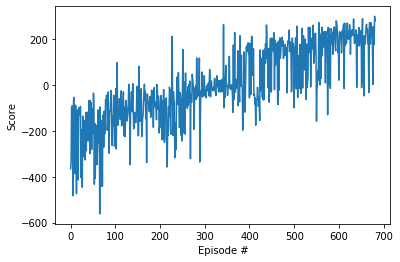

In [32]:
t0 = time.time()
scores = dqn()
print("\nElapsed time: ", time.time() - t0)
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In the graph above we plot the score per episode as training progresses. We can clearly notice that learning is taking place as agent's performance improves.

Next we watch a trained agent interacting in the environment as it solves the task...

In [9]:
time.sleep(20)
for i in range(5):
    print(str(5-i))
    time.sleep(1)
# load the weights from file
agent.qnetwork_local.load_state_dict(torch.load('checkpoint_dqn_backup.pth'))
num_episodes = 3

for i_episode in range(1, num_episodes + 1):
    state = env.reset()
    for j in range(1000):
        action = agent.act(state)
        env.render()
        state, reward, done, _ = env.step(action)
        if done:
            break 
    print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
    sys.stdout.flush() 
            
env.close()

5
4
3
2
1
Episode 3/3.

---
Throughout the years there has been a few imporvements suggested to the original *Deep Q-Learning* algorithm tackling different aspects and shortfalls of the model. Some of the most succesful to date are,

* [Double DQN](https://arxiv.org/pdf/1509.06461.pdf) - tackling the overestimation of the value function inherent to the *Q-Learning* update rule,

* [Prioritised Experience Replay](https://arxiv.org/pdf/1511.05952.pdf) - exploring the fact that not all experiences are as valuable in the learning process,

* [Dueling DQN](https://arxiv.org/pdf/1511.06581.pdf) - exploring alternative network architectures and focusing on calculating the value function $v$ separately.


None of the improvements to the $DQN$ approach can deal directly and effectively with two classes of problems:
* **Continuous Action Spaces** - just like in *Continuous State Spaces* descritisation tends to be a poor solution,
* **Pure Stochastic Policy Solutions** - in some environments with *Aliased States* a deterministic *greedy policy* or even a nearly deterministic *$\epsilon$-greedy* policy can be a suboptimal solution to the problem. This is a subtle but quite crucial point when developing *Trading Agents* for example.

>What is the optimal solution to [**Rock-Paper-Scissors**](https://www.youtube.com/embed/AnRYS02tvRA)?

Now that we are using the full power of *Neural Networks* and the complex *Deep Learning* infrastrcuture to produce the action-value function $q$, we carelessly leave the final step of yielding a policy $\pi$ from $q$ to an old classic maximisation process.

Next we will explore removing $q$ from the process, simplifying the algorithm as we try to **learn** a policy directly from experiences - in a simpler *end-to-end* model. With the simplification comes also greater freedom - we will be able to apply the agorithm to new classes of problems. 



## Policy-Based Methods

We can start once again from first principles and remind ourselves of the objective of the agent - *to maximise the expected total future reward $J$ from the environment*,
$$
J = \mathbb{E}[G_t]
$$

We can expand the expression in terms of the trajectories $\tau$ that the agent will take,

$$
J = \sum_{\tau}P(\tau)G_t(\tau)
$$

where $P(\tau)$ is the probability of the agent experiencing trajectory $\tau$ and $G_t(\tau)$ its total reward.

For a policy $\pi$, we can expand $P(\tau)$ into the environment model terms $p(S_{t+1}, R_{t+1} \mid S_t, A_t)$ and policy components $\pi(A_t \mid S_t)$,

$$
P(\tau) = \prod_{t}p(S_{t+1}, R_{t+1} \mid S_t, A_t)\pi(A_t \mid S_t)
$$

If we now elevate our policy $\pi$ to a neural network with parameters $\theta$, approximating the optimal policy $\pi_*$ we can try to find the gradient of $J$ in terms of $\theta$,

$$
\nabla_\theta J = \nabla_\theta  \sum_{\tau}P(\tau)G_t(\tau) = \sum_{\tau} P(\tau) \frac{\nabla_\theta P(\tau)}{P(\tau)}G_t(\tau) = \sum_{\tau} P(\tau) \nabla_\theta \log(P(\tau))G_t(\tau) = \sum_{\tau} P(\tau) \sum_{t}\nabla_\theta \log(\pi(A_t \mid S_t, \theta)) G_t(\tau), 
$$

we can write the last equation as an expectation explicitly independent of the model $p$ of the environment,

$$
\nabla_\theta J = \mathbb{E}[\sum_{t}\nabla_\theta \log(\pi(A_t \mid S_t, \theta))G_t]
$$


The last equation allow us to define a **Policy Gradient** method that just like the Value-based methods we have studied is a **model-free algorithm of policy optimisation**. 

We sample the environment for a set of trajectories $\tau$, calculate $G_t(\tau)$ and use the **gradient ascent** equation to update $\theta$,

$$
\theta \leftarrow \theta + \alpha \nabla_\theta J
$$

Looking in more detail at the equation for the gradient $\nabla_\theta J$ we can see that the updated $\theta$ will contribute to a policy $\pi$ that attributes a higher probability to the actions $A_{t}$ at state $S_t$ that returned a positive large total reward $G_t$ and reduce the probability of actions $A_t$ that at state $S_t$ returned a large negative total reward $G_t$.

This is a *Monte Carlo* method similar to the *MC Control* method we have introduced before. And just like the MC Control method, pure *Policy Gradient* methods suffer from **high variance** - making them challenging to converge.

That was why when we studied the classical theory we quickly moved on to *TD methods*. Temporal Differences methods have reduce variance as they only introduce one element of randomness at each update step. The trade off is that in TD methods we perform estimates of estimates, so TD methods can suffer from **high bias**.

It seems that if we could incorporate both approches in one single algorithm we could have the best of both worlds. That is indeed the case as we will see next...
___

## Deep Deterministic Policy Gradient - Actor-Critic Methods

An **Actor-Critic** method possesses two sets of neural networks. One **policy** neural network $\pi$ responsable for the agent's actions and an **action-value** neural network $Q$ acting as the *critic* of the policy.  

Next we will introduce the [**Deep Deterministic Policy Gradient**](https://arxiv.org/pdf/1509.02971.pdf) model which is an adaptation to continuous actions of an *actor-critic* method. But first, let's present a problem we will like to solve...

<br>
<figure>
  <img src = "./images/cassie.gif" width = 70% >
      <figcaption style = "text-align: center; font-style: italic">Image: Cassie by Agility Robotics</figcaption>
</figure> 
<br>

[Cassie](https://spectrum.ieee.org/automaton/robotics/industrial-robots/agility-robotics-introduces-cassie-a-dynamic-and-talented-robot-delivery-ostrich) is a [dynamic bipedal robot](http://web.eecs.umich.edu/faculty/grizzle/papers/Feedback_Control_of_a_Cassie_Bipedal_Robot__Standing_and_Walking_Final.pdf) developed by [Agility Robotics](https://www.agilityrobotics.com/) used for research and in the future for disaster relief and delivery of packages.

>[Bipedal Walker](https://gym.openai.com/envs/BipedalWalkerHardcore-v2/). Reward is given for moving forward, total 300+ points up to the far end. If the robot falls, it gets -100. Applying motor torque costs a small amount of points, more optimal agent will get better score. State consists of hull angle speed, angular velocity, horizontal speed, vertical speed, position of joints and joints angular speed, legs contact with ground, and 10 lidar rangefinder measurements. There's no coordinates in the state vector. Hardcore version has ladders, stumps, pitfalls.  Applying motor torque costs a small amount of points, more optimal agent will get better score.

In [10]:
env = gym.make('BipedalWalker-v2')

In [11]:
print('State shape: ', env.observation_space.shape)
print('Number of actions: ', env.action_space.shape)

State shape:  (24,)
Number of actions:  (4,)


In [19]:
from ddpg_agent import DDPG_Agent
agent = DDPG_Agent(state_size=env.observation_space.shape[0], action_size=env.action_space.shape[0], random_seed=10)

In [17]:
time.sleep(20)
for i in range(5):
    print(str(5-i))
    time.sleep(1)
# watch an untrained agent
num_episodes = 5
for i_episode in range(1, num_episodes+1):
    state = env.reset()
    for step in range(1000):
        action = agent.act(state)
        env.render()
        state, reward, done, _ = env.step(action)
        if done:
            break 
    print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
    sys.stdout.flush()    
env.close()

5
4
3
2
1
Episode 5/5.

Episode 100	Average Score: -135.84	Score: -136.17
Episode 200	Average Score: -138.52	Score: -123.95
Episode 300	Average Score: -133.76	Score: -120.75
Episode 400	Average Score: -146.03	Score: -101.29
Episode 500	Average Score: -101.83	Score: -98.572
Episode 600	Average Score: -106.11	Score: -96.149
Episode 700	Average Score: -101.25	Score: -102.03
Episode 800	Average Score: -100.80	Score: -104.58
Episode 900	Average Score: -99.13	Score: -98.0265
Episode 1000	Average Score: -120.10	Score: -134.65

Elapsed time:  8940.479366064072


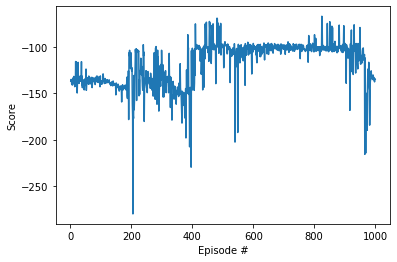

In [15]:
def ddpg(n_episodes=1000, max_t=1000):
    scores_deque = deque(maxlen=100)
    scores = []
    max_score = -np.Inf
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        agent.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_deque.append(score)
        scores.append(score)
        print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}'.format(i_episode, np.mean(scores_deque), score), end="")
        if i_episode % 100 == 0:
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))   
    return scores
t0 = time.time()
scores = ddpg()
print("\nElapsed time: ", time.time() - t0)
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [20]:
agent.actor_local.load_state_dict(torch.load('chpt_actor_trained.pth'))

num_episodes = 3
for i_episode in range(1, num_episodes+1):
    state = env.reset()
    agent.reset()   
    while True:
        action = agent.act(state)
        env.render()
        next_state, reward, done, _ = env.step(action)
        state = next_state
        if done:
            break
    print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
    sys.stdout.flush()  
env.close()

RuntimeError: Error(s) in loading state_dict for Actor:
	Unexpected key(s) in state_dict: "fc3.weight", "fc3.bias". 
	size mismatch for fc1.weight: copying a param with shape torch.Size([400, 24]) from checkpoint, the shape in current model is torch.Size([256, 24]).
	size mismatch for fc1.bias: copying a param with shape torch.Size([400]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for fc2.weight: copying a param with shape torch.Size([300, 400]) from checkpoint, the shape in current model is torch.Size([4, 256]).
	size mismatch for fc2.bias: copying a param with shape torch.Size([300]) from checkpoint, the shape in current model is torch.Size([4]).

[Boston Dynamics](https://www.bostondynamics.com/) is another American engineering and robotics design company. They definitely have the [coolest robot](https://www.youtube.com/watch?v=kVzVekQMUI0) :)

<br>
<figure>
  <img src = "./images/SexyBot.jpg" width = 100% >
      <figcaption style = "text-align: center; font-style: italic">Image: SPOT by Boston Dynamics </figcaption>
</figure> 
<br>